# Trabajo de Fin de Grado - Álvaro López García
## _Grado en Ingeniería Informática_
### Facultad de Ciencias - Universidad de Cantabria


In [1]:
# Celda para importar librerías, costantes, etc.
import tensorflow as tf
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
import mido
import math
import copy

from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from IPython import display

from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

PATH = '/Volumes/TheVault/Documentos Mac/Documentos Universidad/4o Curso/2o Cuatrimestre/Trabajo de Fin de Grado/maestro-v3.0.0/'

### Creación del dataframe

In [2]:
def get_dataframe(path=PATH + 'maestro-v3.0.0.csv'):
    df = pd.read_csv(path)
    return df

In [3]:
df = get_dataframe()
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


### Preprocesado del Dataset

#### Parámetros del procesado

In [4]:
# Parámetros de configuración de los archivos de audio
SAMPLING_RATE = 16000
N_NOTES = 88
N_ROWS = 1

if N_ROWS is not None: 
    num = N_ROWS
else:
    num = len(df)

#### Procesado de los imputs del modelo (MIDI -> np.array)

In [5]:
# DISCLAIMER: Basado en https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

'''
    Los mensajes son eventos que, dependiendo de su tipo nos indican distinto tipo de
    informaciones acerca de lo que sucede en la pista. En este método nos quedamos sólo
    con la información que nos interesa dependiendo del tipo de mensaje.
'''
def msg2dict(msg):
    
    # Declaración de variables
    result = dict()
    key_on = bool()
    
    # Para saber si el mensaje nos indica que una nota esta pulsada en ese momento, o si
    # el mensaje no se refiere a una nota
    if msg.type == 'note_on':
        key_on = True
    elif msg.type == 'note_off':
        key_on = False
    else:
        key_on = None
        
    # Obtenemos la información relativa al tiempo
    result['time'] = msg.time
    
    # En caso de que se trate de una nota, retornamos los atributos que nos interesan
    if key_on is not None:
        result['note'] = msg.note
        result['velocity'] = msg.velocity
    
    return (result, key_on)

'''
    Actualiza el valor de una nota en un nuevo estado para unos valores de velocidad
    faciltados de entrada.
'''
def switch_note(last_state, note, velocity, key_on, n_notes=N_NOTES):
    
    # Si se trata del primer estado de la pista, creamos un array de ceros vacio
    if last_state is None:
        result = np.zeros((n_notes), dtype=int)
    else:
        result = last_state.copy()
    
    # Si la nota esta dentro de los margenes de las que estan en los valores del teclado
    # del piano y se pulsa, actualizamos su velocidad
    if 21 <= note <= 108:
        if key_on:
            result[note-21] = velocity 
        else:
            result[note-21] = 0

    return result

'''
    Devuelve un nuevo estado de acuerdo a un nuevo mensaje. Entendemos por estado, como
    un vector (array) donde cada componente representa el valor de velocidad de una de
    las teclas del piano en un instante de tiempo determinado.
'''
def get_new_state(new_msg, last_state):
    
    # Obtenemos los distintos valores y parámetros del mensaje en cuestión
    new_msg, key_on = msg2dict(new_msg)
    
    if key_on is not None: # Si el mensaje se refiere a un cambio en una nota
        new_state = switch_note(last_state, new_msg['note'], new_msg['velocity'], key_on)
    else: # En caso contrario el estado se mantiene inmutable
        new_state = last_state
    return (new_state, new_msg['time'])

'''
    Transformamos una pista (compuesta de mensajes) en un array bidimensional de estados.
    Hay que convertir los mesajes a estados (np.arrays).
'''
def track2seq(track, n_notes=N_NOTES):
    
    result = [] # Lista donde almacenaremos los distintos estados
    last_state, last_time = get_new_state(track[0], np.zeros((n_notes), dtype=int)) # Obtenemos los primeros valores de estado y tiempo
    
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        
        if new_time > 0: # Añadimos tantas "rodajas" temporales con el ultimo estado como tiempo haya pasado desde la ultima pulsacion  
            result += [last_state] * new_time
        last_state, last_time = new_state, new_time
        
    return np.array(result)

'''
    Devuelve un array con los valores del pianoroll de todas las pistas del midi.
'''
def mid2array(mid, n_notes=N_NOTES):
    
    # Lista donde almacenaremos los valores de las distintas pistas
    all_arys = []
    
    # Calculamos cual va a ser la longitud de nuestro array
    tracks_len = [len(tr) for tr in mid.tracks]
    
    # Obtenemos los np.array(s) de cada pista
    for i in range(1, len(mid.tracks)):
        all_arys.append(track2seq(mid.tracks[i]))
    
    # Convertirmos a np.array y nos quedamos con el valor máximo de una nota de entre todas las pistas
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)

    return all_arys

'''
    Devuelve un pianorroll sampleado al ratio que se proporiciona como argumento de entrada.
'''
def resample_pianoroll(piano_roll, old_sampling_rate, new_sampling_rate):
    
    step = old_sampling_rate / new_sampling_rate
    result = []

    for i in np.arange(0.0, len(piano_roll), step):
        result.append(np.array(np.mean(np.array(piano_roll[int(i):math.ceil(i + step)]), axis=0)))

    return result

'''
    Analiza los mensajes de las pistas de un determinado archivo midi que se pasa como
    argumento de entrada para calcular su sampling rate y lo devuelve.
'''
def get_sampling_rate(midi):
    
    tpb = midi.ticks_per_beat
    t_ms = 500000 # Valor por defecto en el formato midi
    track = midi.tracks[0] # Pista que contiene metapaámetros del archivo
    
    for msg in track:
        if msg.tempo is not None:
            t_ms = msg.tempo
            break
            
    t_s = (10 ** 6) / t_ms
    return tpb * t_s

'''
    Plotea un pianoroll pasado como argumento de entrada.
'''
def plot_pianoroll(pianoroll, title=None):
    plt.figure(figsize=(16,6),dpi=200)
    plt.plot(range(pianoroll.shape[0]), np.multiply(np.where(pianoroll>0, 1, 0), range(1, N_NOTES + 1)), \
             marker='.', markersize=1, linestyle='', color='c')
    plt.xlim(0, pianoroll.shape[0] * 1.05)
    plt.ylim(0, N_NOTES * 1.05)
    if title is not None: plt.title(title)
    plt.show()

'''
    Toma una lista de archivos MIDI y devuelve una lista de pianorolls. Tiene argumentos
    opcionales para especificar el directorio padre desde el que han de leerse los archivos
    MIDI en cuestión y la frecuencia de muestreo a la que han de devolverse.
'''
def vectorize_midis(files, sampling_rate=SAMPLING_RATE, dir_path=PATH):
    
    result = []
    for file in files:
        midi = mido.MidiFile(dir_path + file, clip=True)
        pianoroll = mid2array(midi)
        pianoroll_resampled = resample_pianoroll(pianoroll, get_sampling_rate(midi), sampling_rate)
        result.append(np.array(pianoroll_resampled))
        
    return result

(1, 11263709, 88)


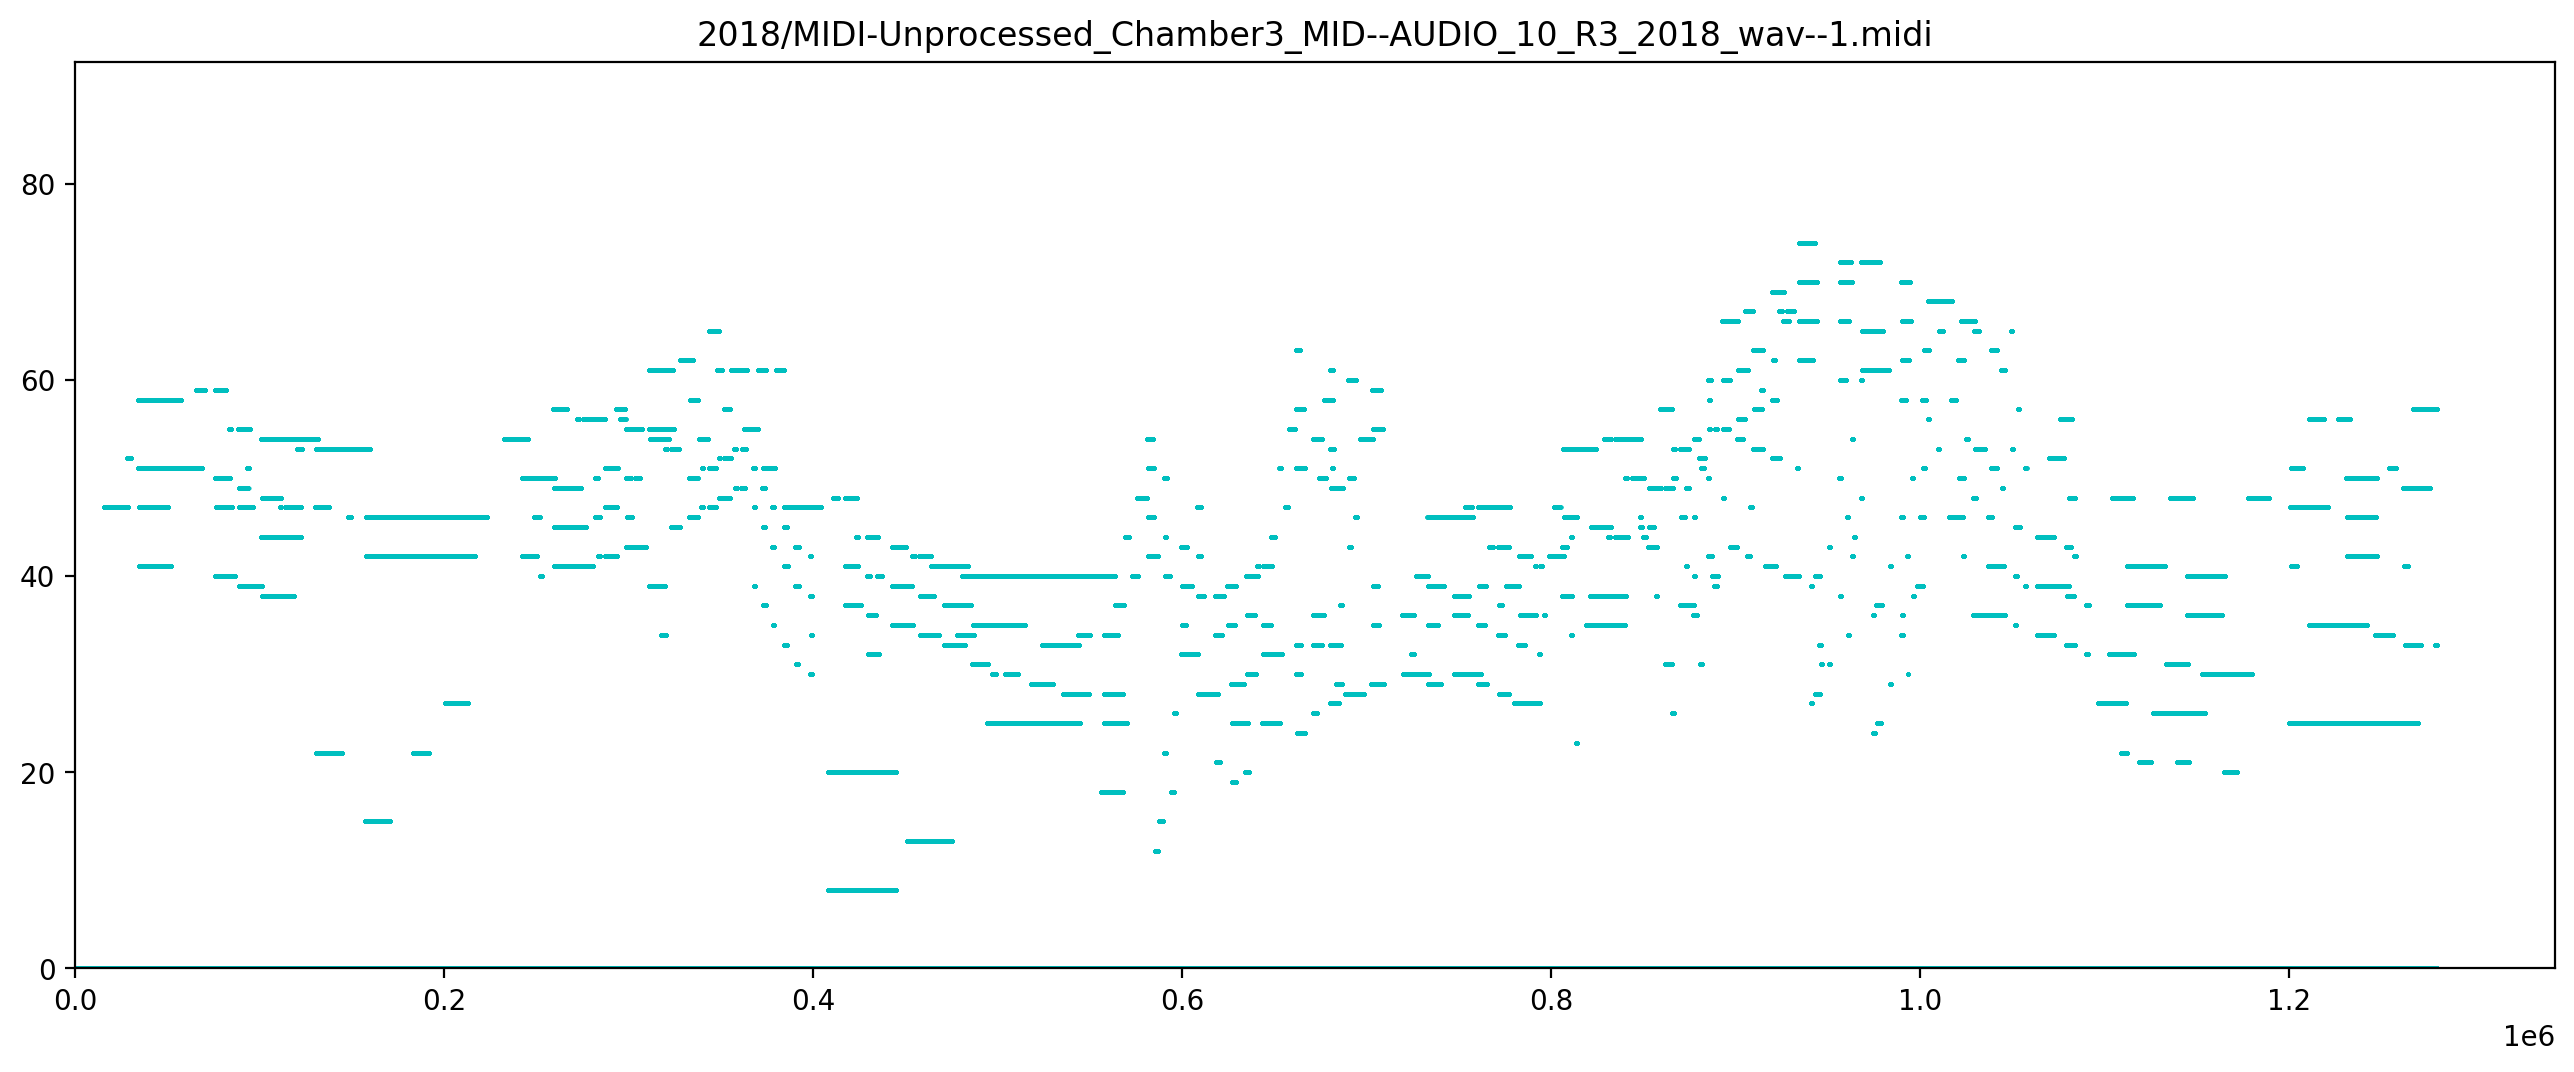

In [6]:
pianorolls = vectorize_midis(df['midi_filename'][0:num])
print(np.array(pianorolls).shape)
plot_pianoroll(pianorolls[0][0:1280000], title=df['midi_filename'][0])

#### Procesado de los valores objetivo (.wav -> np.array)

In [7]:
'''
    Plotea los valores de la onda que han pasado como argumento de entrada.
'''
def plot_wav(waves, title=None):
    wave = waves.flatten()
    plt.figure(figsize=(16,6),dpi=200)
    plt.plot(wave)
    plt.xlim(0, len(wave))
    plt.ylim(min(wave) * 1.05, max(wave) * 1.05)
    if title is not None: plt.title(title)
    plt.show()
    
def split_wav(data, old_sampling_rate, new_sampling_rate):

    duration = librosa.get_duration(y=data, sr=old_sampling_rate)
    sampling_period = 1 / new_sampling_rate
    step = int(len(data) * sampling_period / duration)
    
    tail = len(data) % step
    if tail > 0: data = data[0:-tail]
    result = data.reshape(-1, step)

    return result

'''
    Toma una lista de archivos .wav y devuelve una lista de np.arrays con los valores de la 
    onda por ventanas de tiempo. Tiene argumentos opcionales para especificar el directorio 
    padre desde el que han de leerse los archivos wac en cuestión y la frecuencia de muestreo
    a la que han de devolverse.
'''
def vectorize_wavs(files, sampling_rate=SAMPLING_RATE, dir_path=PATH):
    
    result = []
    
    for file in files:
        data, sr = librosa.load(PATH + file, sr=sampling_rate)
        resampled_data = split_wav(data, sr, sampling_rate)
        result.append(np.array(resampled_data))
    
    return result

(1, 11268399, 1)


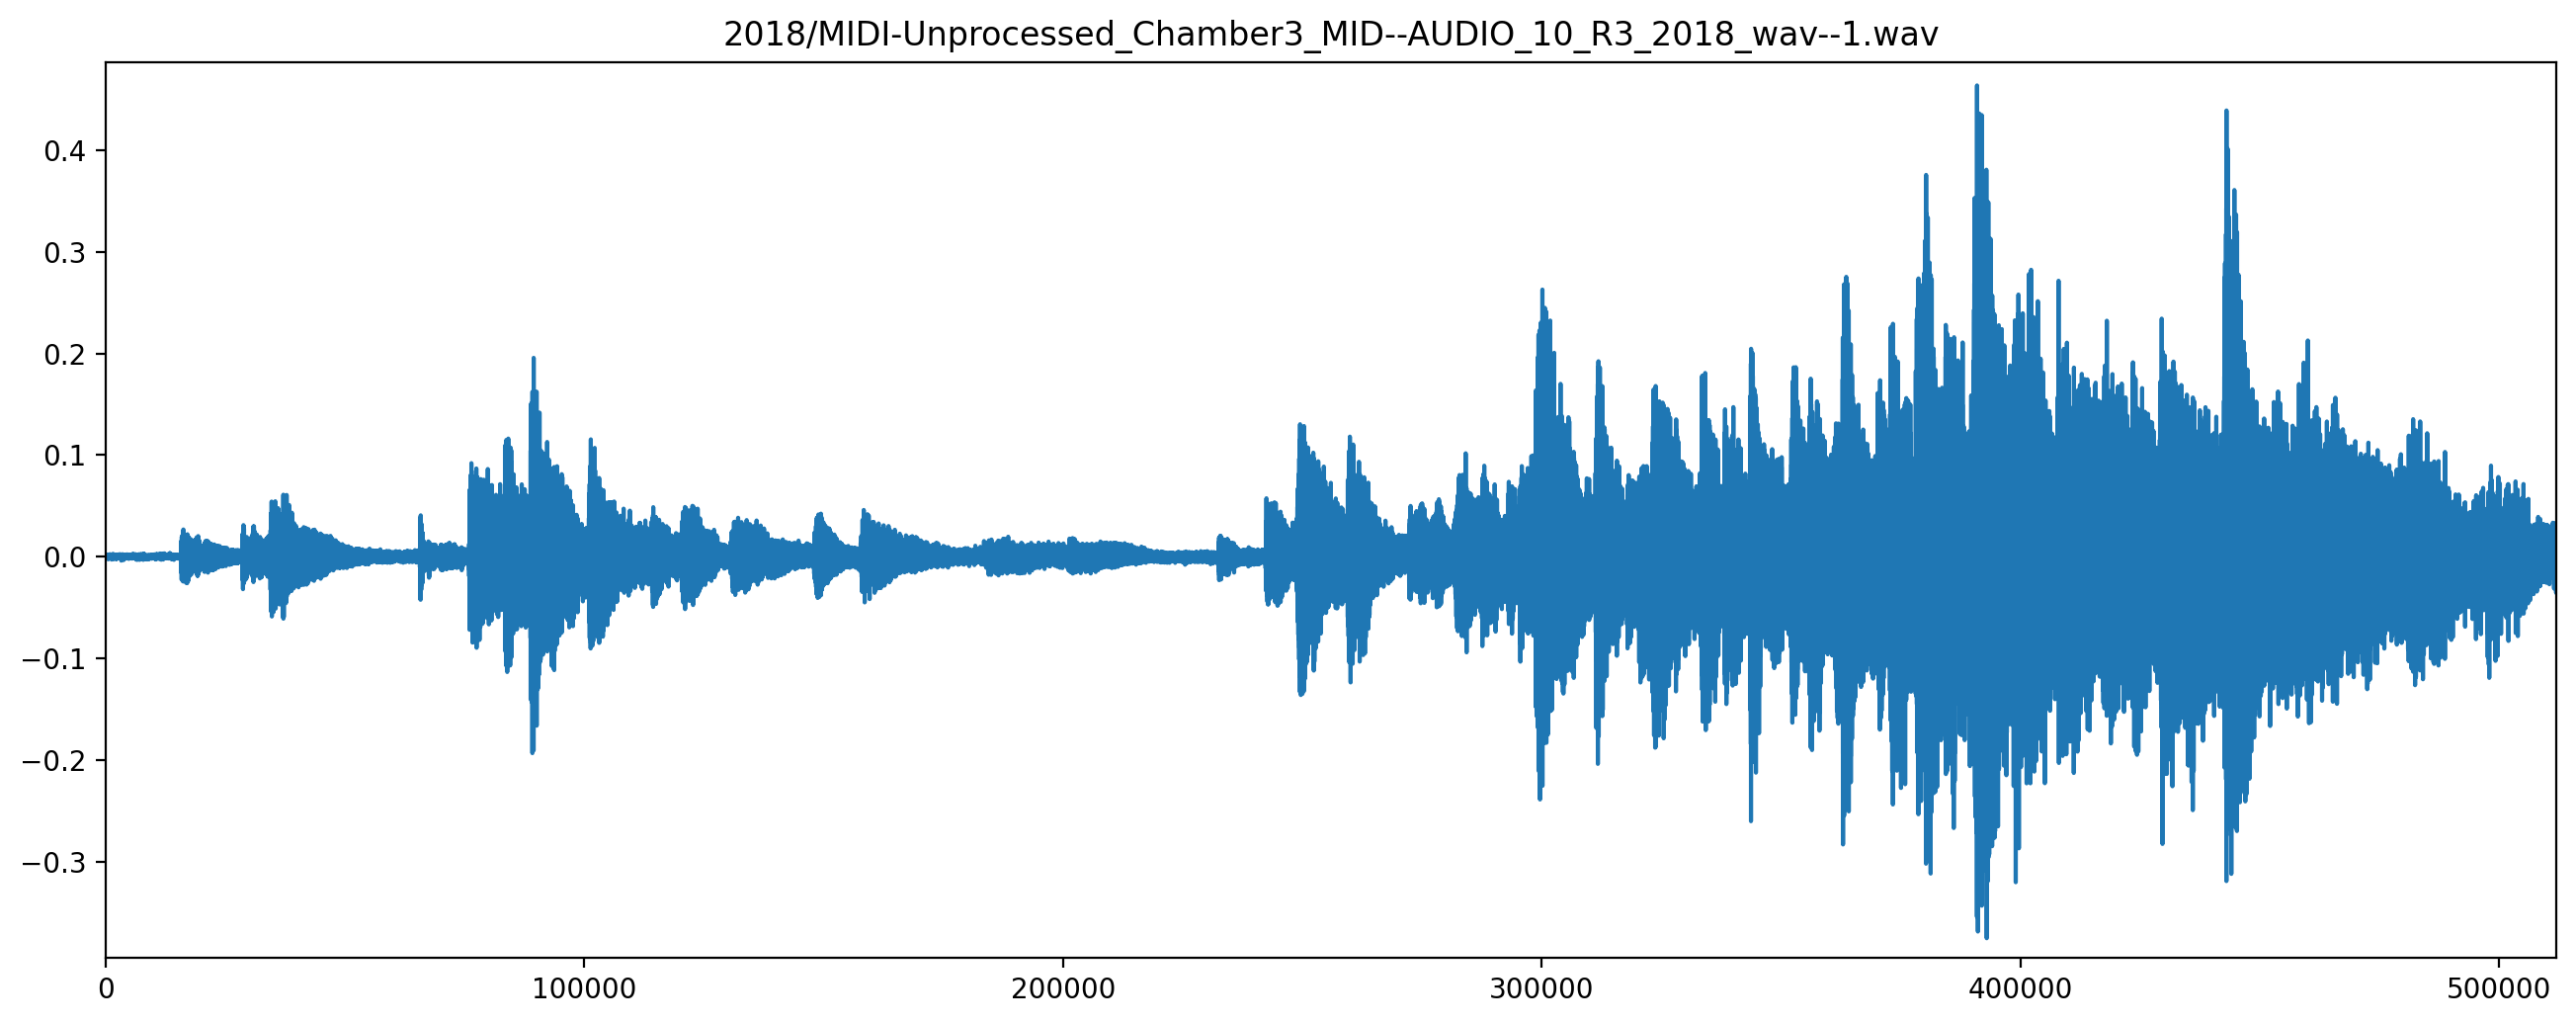

In [8]:
waves = vectorize_wavs(df['audio_filename'][0:num])
print(np.array(waves).shape)
plot_wav(waves[0][0:512000], title=df['audio_filename'][0])

#### Añadiendo los valores reales del entrenamiento del modelo al dataframe del dataset

In [9]:
X = [] # Midis
y = [] # wavs

# Añadimos una columna al dataframe con los datos de input de nuestra red (X) y nuestros 
# targets (y)
for i in range(num):
    tmp_X = pianorolls[i]
    tmp_y = waves[i]
    
    # Provisional hasta arreglar el tema de la precisión
    # TODO: Revisar
    max_len = min(len(tmp_X), len(tmp_y))
    
    X.append(tmp_X[0:max_len])
    y.append(tmp_y[0:max_len])

In [10]:
# Rellenamos con Nones las listas para machear al longitud del dataframe
X += [None] * (df.shape[0] - len(X))
y += [None] * (df.shape[0] - len(y))

df['pianorolls_raw'] = X
df['waves_raw'] = y
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,pianorolls_raw,waves_raw
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00013474046], [0.0003098991], [0.000302120..."
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471,None,None
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,None,None
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,None,None
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,None,None


#### Normalizando los datos de entrada

- Para los datos de entrada aplicaremos la normalización **MinMax** donde cada nuevo valor $x'$ para cada ejemplo $x$ vendrá dado por: $$ x' = \frac{x - min}{max - min} ,$$ donde $max$ y $min$ son los valores máximos y mínimos de los valores de entrada. En este caso, dada la definición del estándar MIDI, sabemos que los valores de estas velocidades ya están parametrizados entre 0 y 127, por lo que podemos pasarlo al normalizador como argumento de entrada y ahorrarnos iterar todos los inputs del dataset.

- Para 

In [11]:
# Constates relativas a los ficheros MIDI
MIDI_MAX = 127
MIDI_MIN = 0

# Constates relativas a los ficheros WAV
WAV_MAX = 1
WAV_MIN = -1
N_BITS = 8
MU = (2 ** N_BITS) - 1

In [12]:
class Normalizer:
    
    def __init__(self, data, bounds=(MIDI_MIN, MIDI_MAX)):
        
        assert isinstance(data, pd.Series)
        
        if None not in bounds:
            
            self.min = bounds[0]
            self.max = bounds[1]
            
        else:
        
            self.min = math.inf
            self.max = -math.inf

            for idx, samples in data.items():
                if samples is not None:
                    for sample in samples:
                        for value in sample:
                            if self.min > value:
                                self.min = value
                            if self.max < value:
                                self.max = value

        self.denominator = self.max - self.min
    
    def normalize_sample(self, sample):
        return (sample - self.min) / self.denominator
    
    def denormalize_sample(self, sample):
        return (sample + self.min) * self.denominator
    
    def normalize_series(self, data):
        assert isinstance(data, pd.Series)
        
        result = []
        
        for idx, samples in data.items():
            if samples is not None:
                tmp = []
                for sample in samples:
                    tmp.append(self.normalize_sample(sample))
                result.append(np.array(tmp))
            else:
                result.append(None)
        
        return pd.Series(result)
    
    def denormalize_series(self, data):
        assert isinstance(data, pd.Series)
        
        result = []
        
        for idx, samples in data.items():
            if samples is not None:
                tmp = []
                for sample in samples:
                    tmp.append(self.denormalize_sample(sample))
                result.append(np.array(tmp))
            else:
                result.append(None)
        
        return pd.Series(result)
    
class Mu_law_encoder:
    
    def __init__(self, data, bounds=(MIDI_MIN, MIDI_MAX), mu=MU):
        
        assert isinstance(data, pd.Series)
        
        self.mu = mu
        self.length = math.ceil(math.log(self.mu, 2))
        self.stepsize=(1.0-(-1.0))/(2 ** self.length)
        
        if None not in bounds:
            
            self.min = bounds[0]
            self.max = bounds[1]
            
        else:
        
            self.min = math.inf
            self.max = -math.inf

            for idx, samples in data.items():
                if samples is not None:
                    for sample in samples:
                        for value in sample:
                            if self.min > value:
                                self.min = value
                            if self.max < value:
                                self.max = value
                                
    def encode_sample(self, sample):
        
        # Compression
        y = np.sign(sample) * (np.log(1 + self.mu * np.abs(sample))) / np.log(self.mu + 1)
        
        # Encoding
        return int(np.floor(y / self.stepsize))
    
    def encode_sample_bitwise(self, data):
        return self.dec_to_ca2(self.encode_sample(data))
    
    def decode_sample(self, sample):
        
        # Decoding
        dec = sample * self.stepsize + self.stepsize / 2
        
        # Decompression
        return np.sign(dec) * (np.exp(np.log(self.mu + 1) * np.abs(dec)) - 1) / self.mu
    
    def decode_sample_bitwise(self, data):
        return self.decode_sample(self.ca2_to_dec(data))

    def encode_series(self, data, bitwise=True):
        assert isinstance(data, pd.Series)
        
        result = []
        
        for idx, samples in data.items():
            if samples is not None:
                tmp = []
                if bitwise:
                    for sample in samples:
                        tmp.append(self.encode_sample_bitwise(sample))
                else:
                    for sample in samples:
                        tmp.append(self.encode_sample(sample))
                result.append(np.array(tmp))
            else:
                result.append(None)
        
        return pd.Series(result)
    
    
    def decode_series(self, data, bitwise=True):
        assert isinstance(data, pd.Series)
        
        result = []
        
        for idx, samples in data.items():
            if samples is not None:
                tmp = []
                if bitwise:
                    for sample in samples:
                        tmp.append(self.decode_sample_bitwise(sample))
                else:
                    for sample in samples:
                        tmp.append(self.decode_sample(sample))
                result.append(np.array(tmp))
            else:
                result.append(None)
        
        return pd.Series(result)
    
    def dec_to_ca2(self, num):
    
        assert isinstance(num, int)

        bits = [int(i) for i in str(bin(num % (1<<self.length)))[2:]]

        if num >= 0:
            for _ in range(self.length - len(bits)):
                bits.insert(0, 0)

        return bits

    def ca2_to_dec(self, bits):

        assert isinstance(bits, list) or isinstance(bits, np.ndarray)
        assert len(bits) <= self.length

        num = -bits[0] * 2 ** (self.length - 1)
        
        for i in range(1, self.length):
            num += bits[i] * 2 ** (self.length - i - 1)

        return num

In [13]:
in_norm = Normalizer(df['pianorolls_raw'])
out_enc = Mu_law_encoder(df['waves_raw'])
df['local_conditioning'] = in_norm.normalize_series(df['pianorolls_raw'])
df['waves_encoded'] = out_enc.encode_series(df['waves_raw'], bitwise=False)
df.head() # Normalized both inputs and outputs

KeyboardInterrupt: 

In [ ]:
# Celda de ejemplo para plotear la diferencia entre la señal real y la aproximada
N_EXAMPLES = 3200
wav_real = df['waves_raw'][0][0:N_EXAMPLES]
wav_aprox = out_enc.decode_series(df['waves_encoded'], bitwise=False)[0][0:N_EXAMPLES]

plt.figure(figsize=(16,6),dpi=200)
plt.plot(wav_real, label='Onda original')
plt.plot(wav_aprox, label='Onda comprimida')
plt.xlim(0, N_EXAMPLES - 1)
plt.legend(loc="upper left")
plt.ylim(min(min(wav_real), min(wav_aprox)) * 1.05, \
         max(max(wav_real), max(wav_aprox)) * 1.05)
plt.title('Onda real VS Onda comprimida')
plt.show()

# Creación del modelo
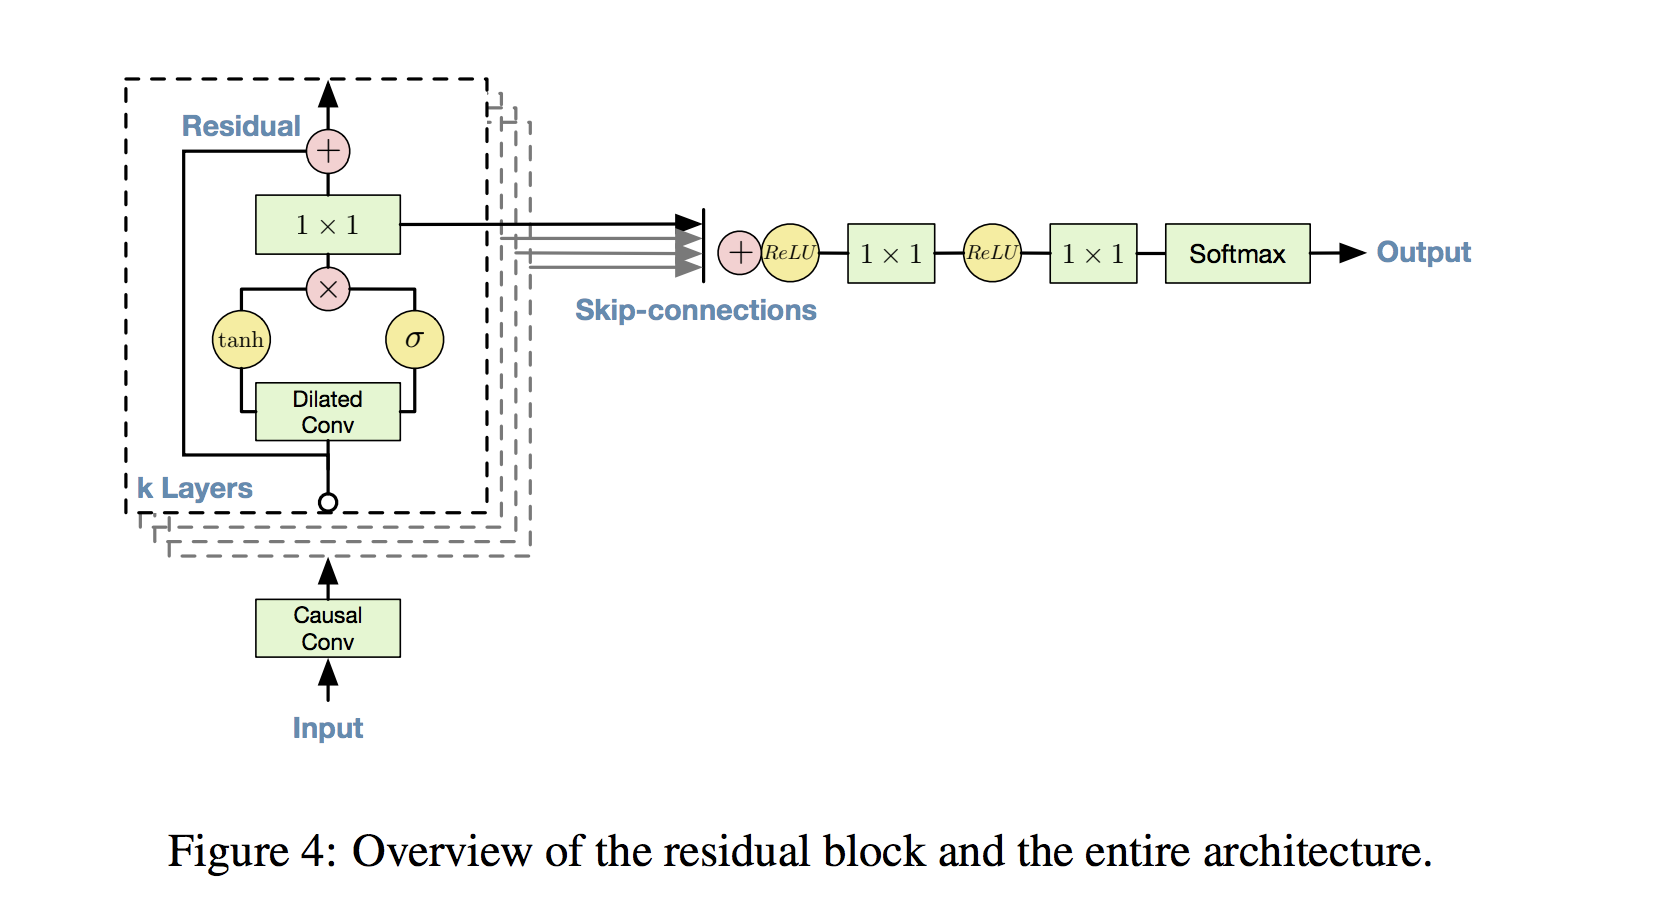

<div>
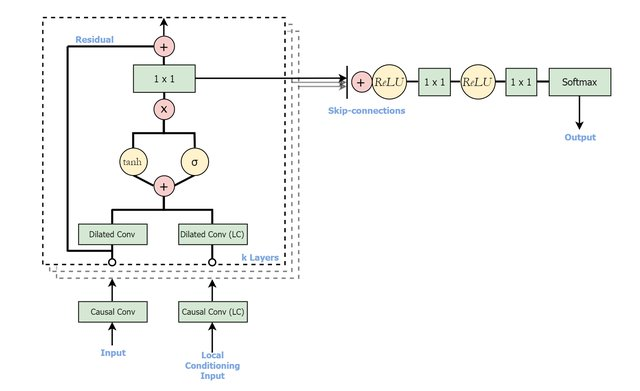
</div>

In [ ]:
# Parámetros que definen la arquitectura del modelo a crear por defecto en las llamadas a get_wavenet()

# Números y longitudes de ejemplos de entrada, salida y local conditioning
INPUT_LEN = MU + 1
N_INPUTS = 1
OUTPUT_LEN = MU + 1
N_OUTPUTS = 1
LC_LEN = len(df['local_conditioning'][0][0])
N_LC = 1

# Dimensionalidad de input/output/local conditioning
INP_SHAPE = (1, N_INPUTS * INPUT_LEN)
OUT_SHAPE = (1, N_OUTPUTS * OUTPUT_LEN)
LC_SHAPE = (1, N_LC * LC_LEN)

# Parámetros de la arquitectura interna de la red
N_FILTERS = 64
FILTER_WIDTH = 2
N_BLOCKS = 2
K_LAYERS = 8

In [ ]:
'''
    Foo
'''
def get_wavenet(inp_shape=INP_SHAPE, out_shape=OUT_SHAPE, lc_shape=LC_SHAPE, n_filters=N_FILTERS, \
                filter_width=FILTER_WIDTH, k_layers=K_LAYERS, n_blocks=N_BLOCKS):
    
    dilation_rates = [2 ** i for i in range(k_layers)] * n_blocks
    
    # Input
    Input_seq = tf.keras.layers.Input(shape=inp_shape, dtype='float32', name='seq')
    x = Input_seq
    
    # Input Convolution
    x = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', activation='relu')(x) 
    # padding='same' añade 0 en los bordes de la entrada para la convolción
    
    # Local Conditioning
    Input_lc = tf.keras.layers.Input(shape=lc_shape, dtype='float32', name='lc')
    lc = Input_lc

    # Local Conditioning Convolution
    lc = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', activation='relu')(lc)

    skips = []
    for dilation_rate in dilation_rates:
        
        x_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                        dilation_rate=dilation_rate)(x)
        
        lc_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                         dilation_rate=dilation_rate)(lc)

        tmp = tf.keras.layers.Add()([x_conv, lc_conv])

        # Multiplicamos las ramas de Filter y Gating
        z = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(tmp),
                                        tf.keras.layers.Activation('sigmoid')(tmp)])
        
        z = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                   activation='relu')(z)

        # Residual connection
        x = tf.keras.layers.Add()([x, z])    

        # Vamos añadiendo las 'Skip conections'
        skips.append(z)

        # x -> Residual
        # z -> Skip connections -> ...

    # Sumamos todas las skip connections y computamos el resto de funciones
    out = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same')(tf.keras.layers.Add()(skips))
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same')(out)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(out_shape[1], out_shape[0], padding='same')(out)
    out = tf.keras.layers.Softmax()(out)
    return tf.keras.models.Model(inputs=[Input_seq, Input_lc], outputs=out)

model = get_wavenet()
model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

### Entrenamiento del modelo

In [ ]:
# Parámetros de entrenamiento
N_EPOCHS = 10
BATCH_SIZE = 10
N_FOLDS = 5
CPU_CORES = 8

In [ ]:
# To avoid kernel dying because of memory limits
N_CHUNKS = 1024

'''
    Foo
'''
def get_datasets(df : pd.DataFrame, n_chunks=N_CHUNKS, input_len=INPUT_LEN, output_len=OUTPUT_LEN, \
                inp_shape=INP_SHAPE, out_shape=OUT_SHAPE, lc_shape=LC_SHAPE):

    # Data gathering
    in_datasets = []
    lc_datasets = []
    target_datasets = []
    
    # Iteramos los ejemplos del dataframe de chunk en chunk
    for local_conditioning, wave in zip(df['local_conditioning'], df['waves_encoded']):
        if None is not local_conditioning and None is not wave: 
            for lc_chunk, wav_chunk in zip(np.array_split(local_conditioning, n_chunks), \
                                           np.array_split(wave, n_chunks)):

                # Input for audio reggresion
                in_datasets.append(tf.data.Dataset.from_tensor_slices(np.fromfunction(lambda i, j: wav_chunk[i + j], \
                                            (len(wav_chunk) - input_len + 1, input_len), dtype=int)[0:-1]))

                # Input for local conditioning
                lc_datasets.append(tf.data.Dataset.from_tensor_slices(lc_chunk[0:-input_len]))

                # Output with one-hot encoding
                target_datasets.append(tf.data.Dataset.from_tensor_slices(tf.keras.utils.to_categorical( \
                                            wav_chunk[input_len:]+int(input_len/2), num_classes=output_len)))

    # Obtenemos los primeros elementos de cada para concatenar todos los datasets si las filas no son None (dev)
    if len(in_datasets) > 0 and len(lc_datasets) > 0 and len(target_datasets) > 0:
        in_ = in_datasets.pop(0)
        lc_ = lc_datasets.pop(0)
        target_ = target_datasets.pop(0)

        for a, b, c in zip(in_datasets, lc_datasets, target_datasets):
            in_ = in_.concatenate(a)
            lc_ = lc_.concatenate(b)
            target_ = target_.concatenate(c)
            
    else:
        in_ = tf.data.Dataset.from_tensor_slices(tf.zeros([*inp_shape]))
        lc_ = tf.data.Dataset.from_tensor_slices(tf.zeros([*lc_shape]))
        target_ = tf.data.Dataset.from_tensor_slices(tf.zeros([*out_shape]))

    return in_, lc_, target_

'''
    Foo
'''
def merge_datasets(in_, lc_, target_, batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, cpu_cores=CPU_CORES):
    dataset = tf.data.Dataset.zip((in_, lc_, target_))
    dataset = dataset.map(lambda i, j, k: ({"seq": tf.expand_dims(i, 0), \
                                                 "lc": tf.expand_dims(j, 0)}, \
                                                 tf.expand_dims(k, 0)), \
                                                num_parallel_calls=cpu_cores)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat(n_epochs)
    return dataset

In [ ]:
# Default Train - Test - Validation split ~ (0.75, 15, 10)
train, test, val = df[df['split'] == 'train'], df[df['split'] == 'test'], df[df['split'] == 'validation']

In [ ]:
in_train, lc_train, target_train = get_datasets(train)
dataset_train = merge_datasets(in_train, lc_train, target_train)
dataset_train

In [ ]:
in_test, lc_test, target_test = get_datasets(test)
dataset_test = merge_datasets(in_test, lc_test, target_test)
dataset_test

In [ ]:
in_val, lc_val, target_val = get_datasets(val)
dataset_val = merge_datasets(in_val, lc_val, target_val, n_epochs=1)
dataset_val

In [ ]:
print(f'Comenzando el entrenamiento del modelo (nº de ejemplos: {int(len(dataset_train)/N_EPOCHS)}, nº de epochs: {N_EPOCHS})...')

histories = []

checkpoint = tf.keras.callbacks.ModelCheckpoint("best.hdf5", monitor='val_accuracy', save_best_only=True, mode='max')
model = get_wavenet()
model.compile(tf.keras.optimizers.Adam(), loss=tf.nn.log_poisson_loss, metrics=["accuracy"])

print('------------------------------------------------------------------------')

history = model.fit(dataset_train, steps_per_epoch=len(dataset_train)/N_EPOCHS, \
                    epochs=N_EPOCHS, validation_data=dataset_val, callbacks=[checkpoint])

histories.append(history)

In [131]:
# 577ms -> 10ms
'''
    Helper function to plot keras history.
    https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
'''
def plot_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Cross Validation'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Cross Validation'], loc='upper left')
    plt.show()

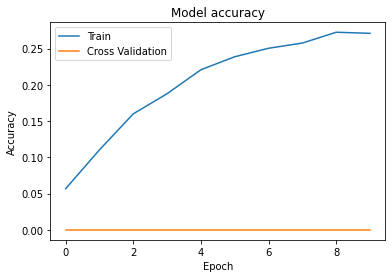

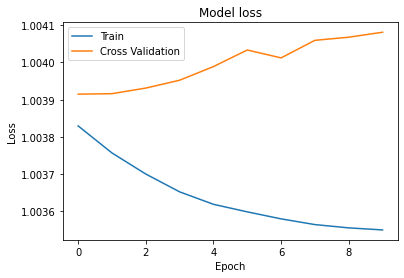

In [132]:
for h in histories:
    plot_history(h)

### Predicción

In [50]:
predictor = tf.keras.models.load_model('./best.hdf5')
predictor.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq (InputLayer)               [(None, 1, 120)]     0           []                               
                                                                                                  
 lc (InputLayer)                [(None, 1, 88)]      0           []                               
                                                                                                  
 conv1d_677 (Conv1D)            (None, 1, 32)        7712        ['seq[0][0]']                    
                                                                                                  
 conv1d_678 (Conv1D)            (None, 1, 32)        5664        ['lc[0][0]']                     
                                                                                           

                                                                                                  
 add_377 (Add)                  (None, 1, 32)        0           ['add_375[0][0]',                
                                                                  'conv1d_690[0][0]']             
                                                                                                  
 conv1d_691 (Conv1D)            (None, 1, 32)        2080        ['add_377[0][0]']                
                                                                                                  
 conv1d_692 (Conv1D)            (None, 1, 32)        2080        ['conv1d_678[0][0]']             
                                                                                                  
 add_378 (Add)                  (None, 1, 32)        0           ['conv1d_691[0][0]',             
                                                                  'conv1d_692[0][0]']             
          

In [107]:
def predict_midi(in_file, out_file, dir_path, predictor, sr=SAMPLING_RATE):
    
    #pianoroll = vectorize_midis([dir_path + in_file], sampling_rate=sr, dir_path=dir_path)[0]
    
    wav = [0] * (N_INPUTS * ITEM_LEN)
    y = []
    
    for i in range(len(pianoroll[:48000])):
        a = np.array(wav[-N_INPUTS * ITEM_LEN:], dtype=int).reshape(1, N_INPUTS * ITEM_LEN)
        b = pianoroll[i].reshape(1, N_NOTES)
        prediction = predictor.predict([a[None,:,:], b[None,:,:]])
        wav = [*wav, *prediction[0,0,:]]
        if i > 2000: print(*prediction[:], np.sum(*prediction[:]))
        y.append(out_enc.decode_sample_bitwise(prediction[0,0,:]))
   
    sf.write(dir_path + out_file, y, sr, 'PCM_24')


In [115]:
in_file = 'test.midi'
out_file = 'prediction.wav'
dir_path = './'
predict_midi(in_file, out_file, dir_path, model)

[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.134183

[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.13418365]] 0.99999994
[[0.09637818 0.11301326 0.01946168 0.22529614 0.00856102 0.07560286
  0.09828656 0.10809638 0.12112026 0.134183

KeyboardInterrupt: 

In [55]:
pianoroll = vectorize_midis([dir_path + in_file], sampling_rate=SAMPLING_RATE, dir_path=dir_path)[0]

In [57]:
print(pianoroll[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [164]:
out_enc.decode_sample_bitwise([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

6.63927370475142e-06